### Interação e Concorrência - Computação Quântica - Projeto Final
#### Trabalho realizado por:

* Breno Fernando Guerra Marrão, A97768
* Tiago Passos Rodrigues, A96414

In [1]:
import qiskit.tools.jupyter
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_distribution
from qiskit.circuit.library import MCMT
from qiskit.circuit.classicalfunction.boolean_expression import BooleanExpression
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle, OR,ZGate, MCXGate

import matplotlib.pyplot as plt
import numpy as np

#### Função para executar circuitos

In [2]:
def execute_circuit(qc, shots=1024, decimal=False, reversed=False):
    
    #define backend
    device = Aer.get_backend('qasm_simulator')
    #get counts
    counts = execute(qc, device ,shots=shots).result().get_counts()
    
    if decimal:
        if reversed:
            counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
        else:
            counts = dict((int(a,2),b) for (a,b) in counts.items())
    else:
        if reversed:
            counts = dict((a[::-1],b) for (a,b) in counts.items())
        else:
            counts = dict((a,b) for (a,b) in counts.items())

    return counts

# Phase Oracle

In [3]:
def func1 (expression):
    oracle = PhaseOracle.from_dimacs_file('dimacs.txt')
    lines = expression.split("\n")
    n_qubits = int(lines[1].split(" ")[2])
    n_formulas = int(lines[1].split(" ")[3])

    qr = QuantumRegister(n_qubits, name = "psi")
    cr = ClassicalRegister(n_qubits)

    qc = QuantumCircuit(qr,cr)

    #uniform superposition qr

    qc.h(qr)
    

    elements = 2**n_qubits

    iterations= int(np.floor(np.pi/4 * np.sqrt(elements)))

    for j in range(iterations):

        qc.barrier()
        qc = qc.compose(oracle)
        qc.barrier()
        
        #diffusion operator


        qc.h(qr)
        qc.x(qr)
        c3z= MCMT('cz',n_qubits-1,1)
        qc.compose(c3z,qubits=range(n_qubits),inplace=True)
        qc.x(qr)
        qc.h(qr)
    
    #for i in range(2,len(lines)):
    return qc,qr,cr




#### Exemplo de uma fórmula boleana com 5 cláusulas e 3 variáveis cada - 3-SAT

f(v1,v2,v3) = ( ¬v1 ∨ ¬v2 ∨ ¬v3) ∧ (v1 ∨ ¬v2 ∨ v3) ∧ (v1 ∨ v2 ∨ ¬v3) ∧ (v1 ∨ ¬v2 ∨ ¬v3) ∧ ( ¬v1 ∨ v2 ∨ v3)

In [4]:
expression = '''
c example DIMACS CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
'''

with open('dimacs.txt', 'r') as f:
    expression = f.read()

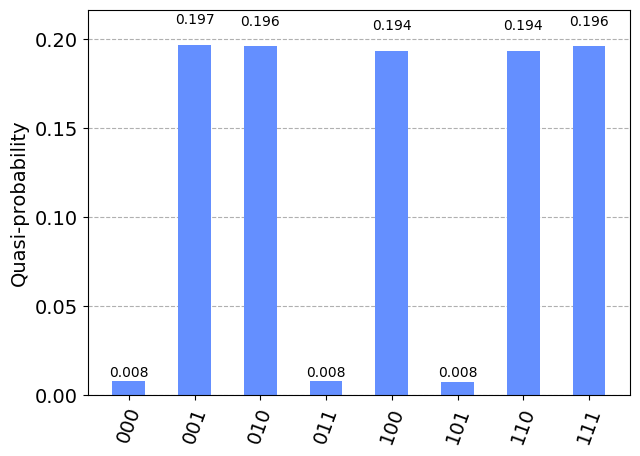

In [5]:
qc,qr,cr = func1(expression)
qc.measure(qr,cr)
#qc.measure_all()
counts = execute_circuit(qc,shots= 100000)
plot_distribution(counts)

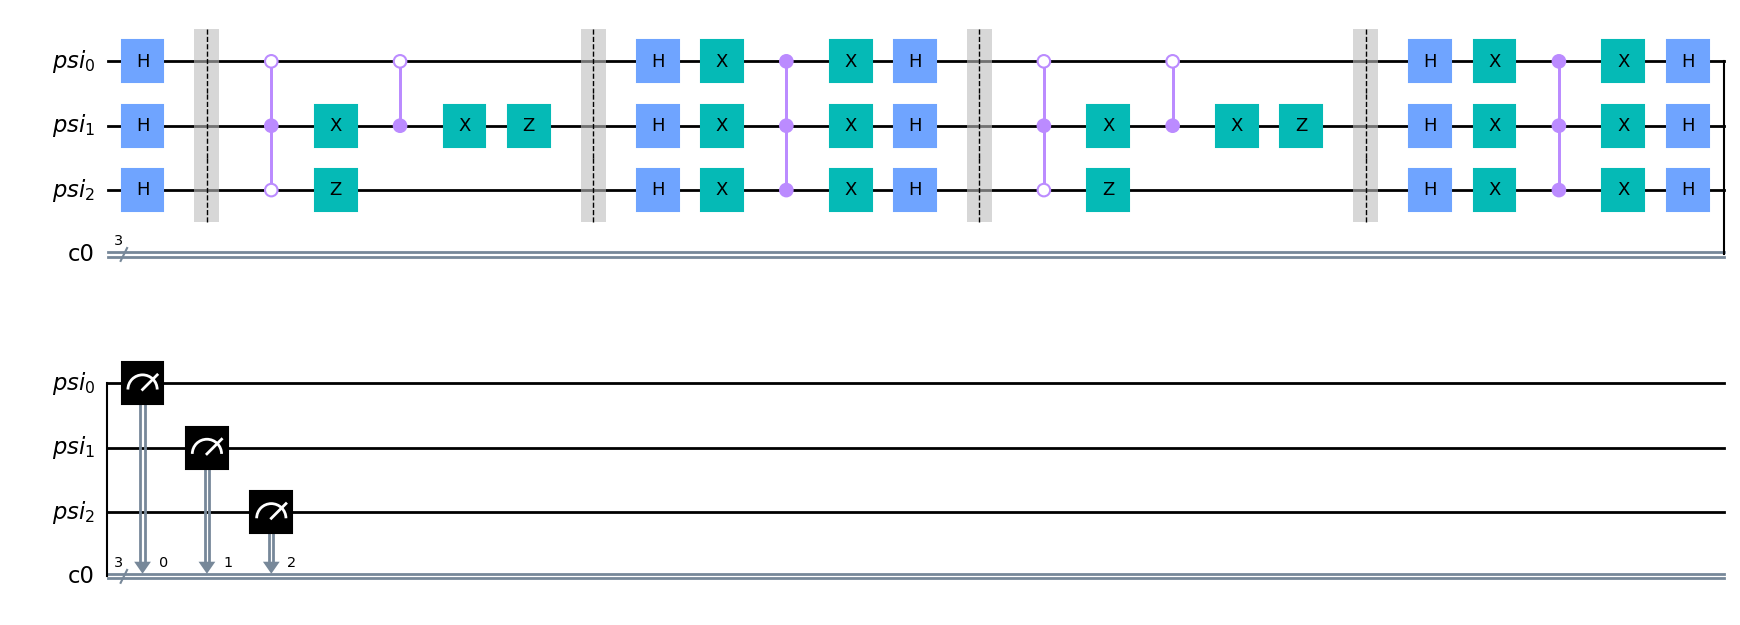

In [6]:
qc.draw(output="mpl")

# Resolução por cláusula

In [32]:
def func (expression):
    lines = expression.split("\n")
    n_qubits = int(lines[1].split(" ")[2])
    n_formulas = int(lines[1].split(" ")[3])

    qr = QuantumRegister(n_qubits, name = "psi")
    #ancilla = QuantumRegister(n_formulas, name = "ancilla")
    ancilla = QuantumRegister(1, name = "ancilla")

    sat = QuantumRegister(1, name = "sat")


    cr = ClassicalRegister(n_qubits)
    cr2 = ClassicalRegister(1)

    

    qc = QuantumCircuit(qr,ancilla,sat,cr,cr2)

    #uniform superposition qr

    qc.h(qr)

    #|-> state ancilla
    qc.x(ancilla)
    qc.h(ancilla)
    
     #|-> state ancilla
    qc.x(sat)
    qc.h(sat)
    
    elements = 2**n_qubits

    iterations= int(np.floor(np.pi/4 * np.sqrt(elements)))

    for j in range(iterations+1):

        qc.barrier()

        #Oracle
        for i in range(n_formulas):
            #Oracle
            valores = []
            line = lines[i+2].split(" ")
            for j in range(n_qubits):
                if line[j][0] == '-':
                    valores.append(-1)
                else:
                    valores.append(1)
            #valores += [0 for a in range(i)]
            c6z = OR(n_qubits,flags=valores)
            qc = qc.compose(c6z)
            qc.barrier()

        #diffusion operator


        qc.h(qr)
        qc.x(qr)
        c3z= MCMT('cz',n_qubits-1,1)
        qc.compose(c3z,qubits=range(n_qubits),inplace=True)
        qc.x(qr)
        qc.h(qr)
        
    
    qc.barrier()

    qc.barrier()
    #qc.x(ancilla)
    qc.mct(ancilla,sat)
    qc.h(sat)

    qc.barrier()

    
    #for i in range(2,len(lines)):
    return qc,qr,sat,cr,cr2


#### Exemplo de uma fórmula boleana com 5 cláusulas e 3 variáveis cada - 3-SAT

f(v1,v2,v3) = ( ¬v1 ∨ ¬v2 ∨ ¬v3) ∧ (v1 ∨ ¬v2 ∨ v3) ∧ (v1 ∨ v2 ∨ ¬v3) ∧ (v1 ∨ ¬v2 ∨ ¬v3) ∧ ( ¬v1 ∨ v2 ∨ v3)

In [33]:
expression = '''
c example DIMACS CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
'''

with open('dimacs.txt', 'r') as f:
    expression = f.read()

print(expression)

c example DIMACS CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0



##### Testando se a fórmula boleana 3-sat é satisfazível

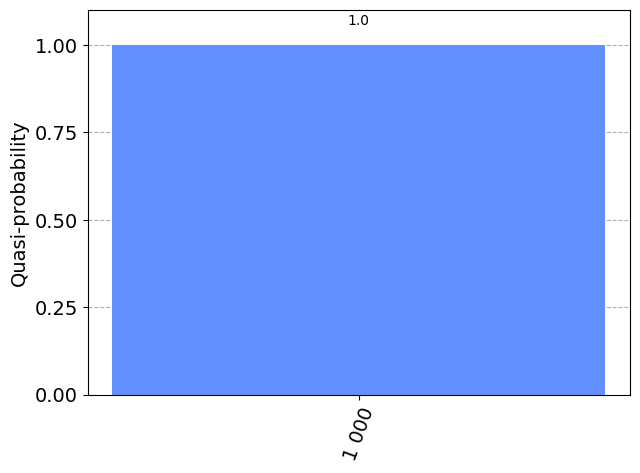

In [34]:
qc,qr,sat,cr,cr2= func(expression)
qc.measure(sat,cr2)

#qc.measure_all()
counts = execute_circuit(qc,shots= 100000)
plot_distribution(counts)

##### Soluções que satisfazem a fórmula 

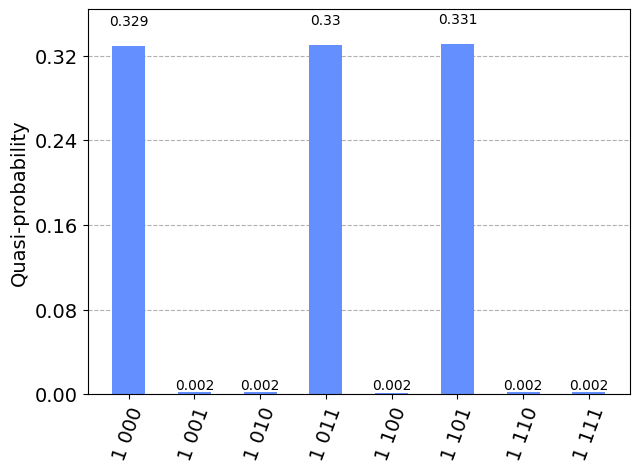

In [35]:
qc.measure(qr,cr)

#qc.measure_all()
counts = execute_circuit(qc,shots= 100000)
plot_distribution(counts)

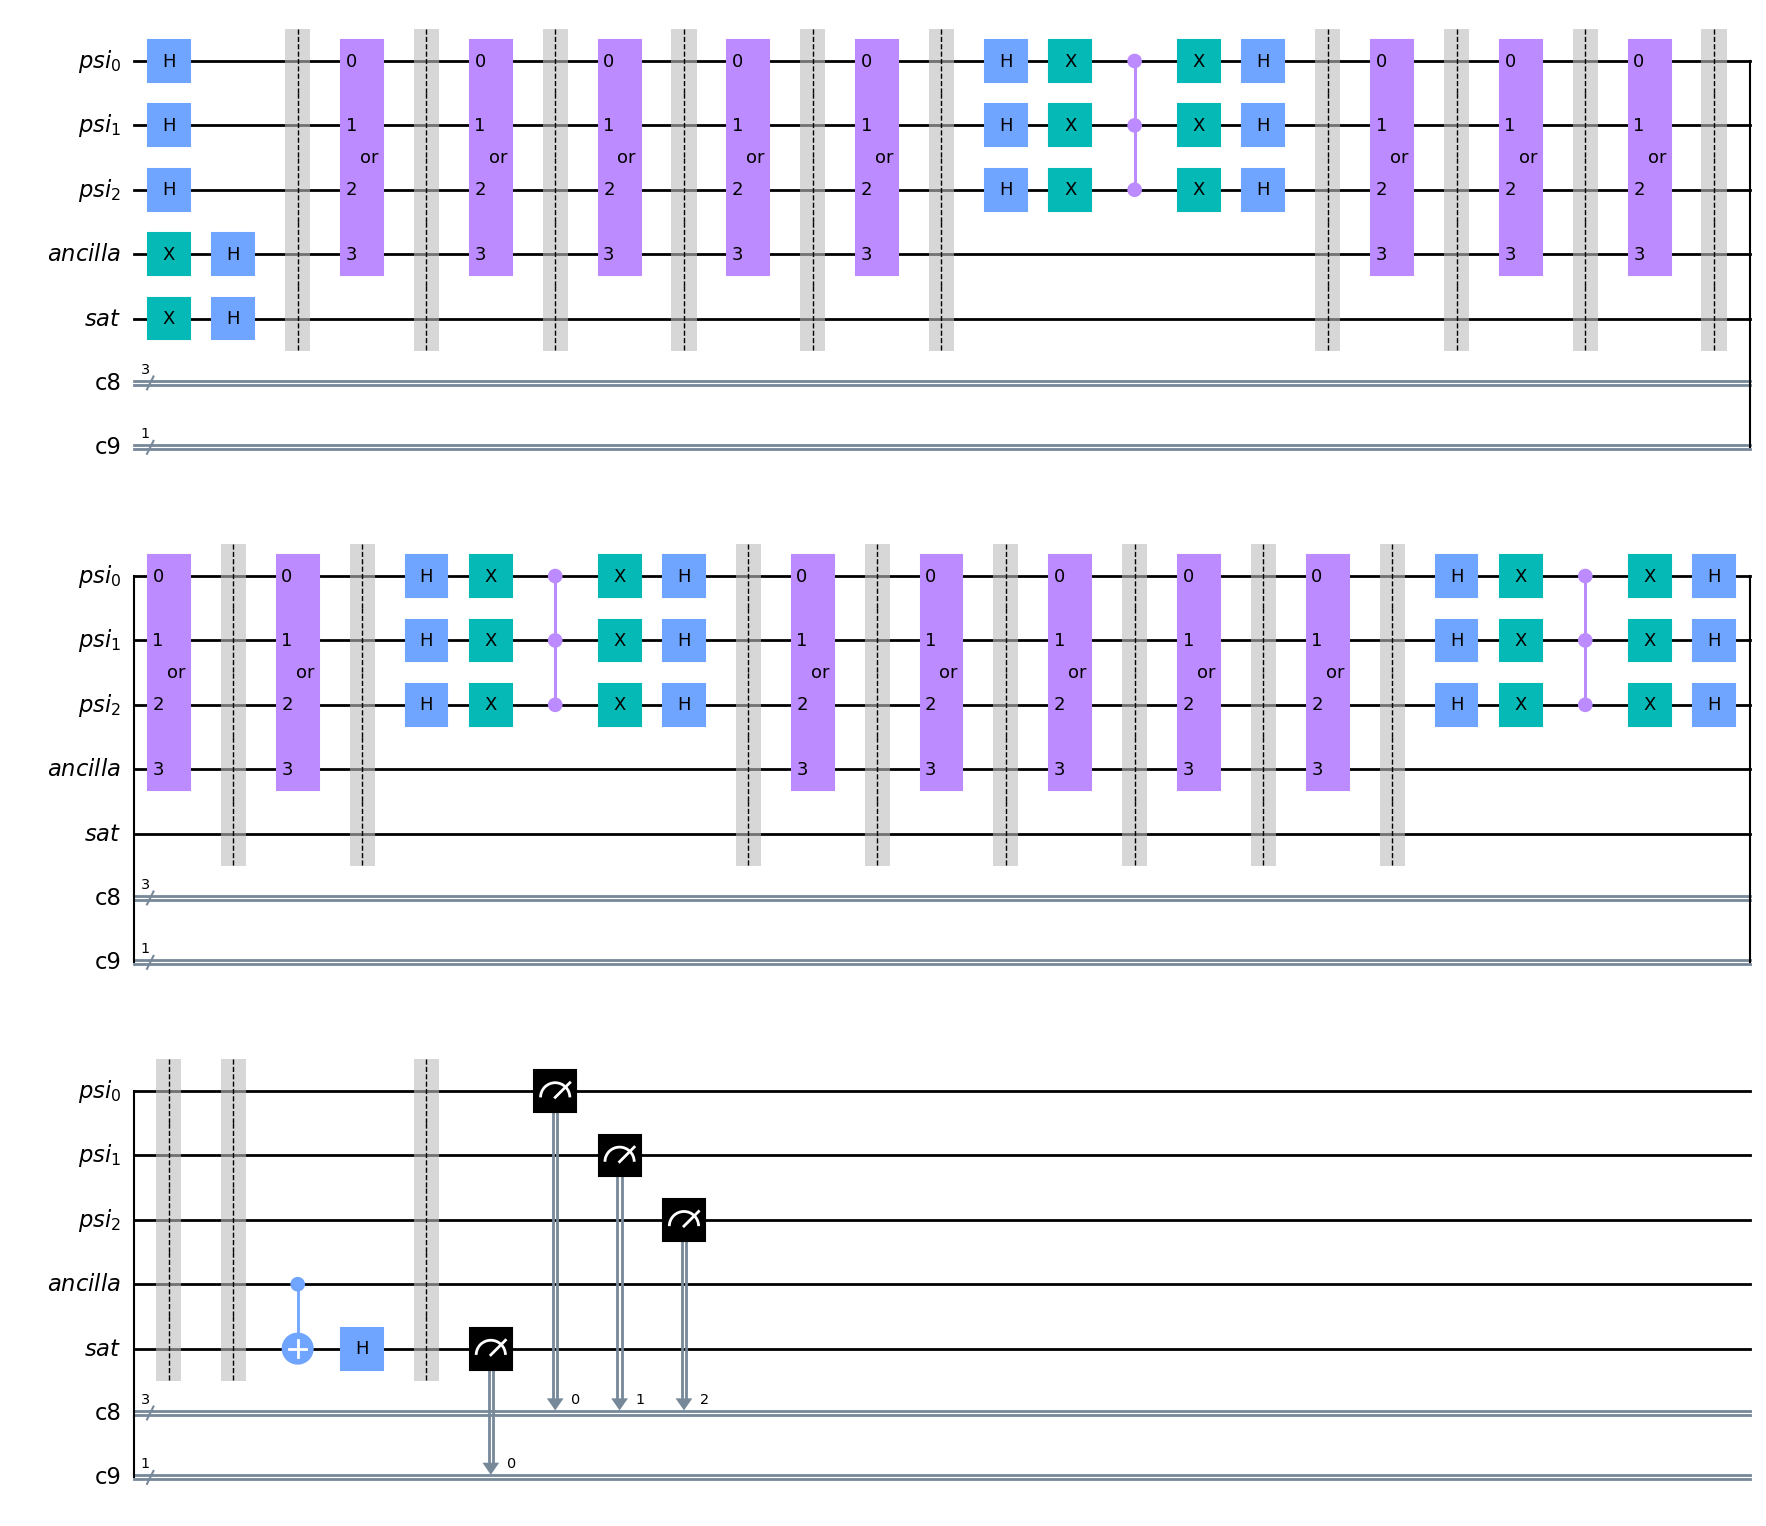

In [36]:
qc.draw(output="mpl")

### Procura por soluções

In [21]:
def oracle(qr, ancilla, bitstring=None):

    qc = QuantumCircuit(qr,ancilla)

    for i in bitstring:
        cx_gate = MCXGate(len(qr),ctrl_state=i)
        qc = qc.compose(cx_gate)
        qc.barrier()
    
    
    return qc

In [22]:
def diffusion_operator(qr, ancilla):

    qc = QuantumCircuit(qr,ancilla)

    qc.h(qr)
    qc.x(qr)
    cz = ZGate().control(len(qr)-1,ctrl_state="1"*(len(qr)-1))
    qc = qc.compose(cz)
    qc.x(qr)
    qc.h(qr)

    qc.barrier()

    return qc

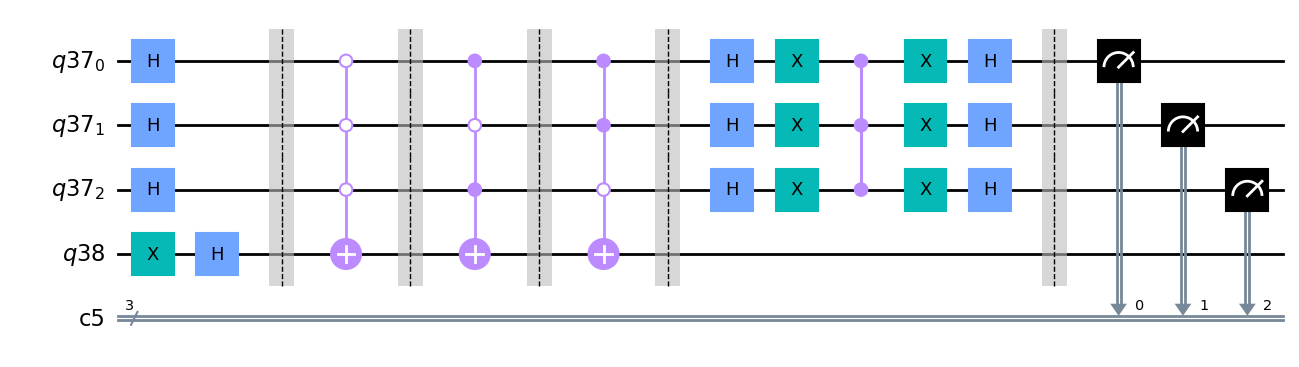

In [25]:
n_qubits = 3
elements = 2**n_qubits
solutions = ['000','101','011']

qr=QuantumRegister(3)
ancilla=QuantumRegister(1)
cr=ClassicalRegister(3)
qc = QuantumCircuit(qr,ancilla,cr)
iterations= int(np.floor(np.pi/4 * np.sqrt(elements/len(solutions))))
qc.h(qr)
qc.x(ancilla)
qc.h(ancilla)
for j in range(iterations):
    qc.barrier()
    qc = qc.compose(oracle(qr,ancilla,bitstring=solutions))
    qc = qc.compose(diffusion_operator(qr,ancilla))

qc.measure(qr,cr)
qc.draw(output="mpl")

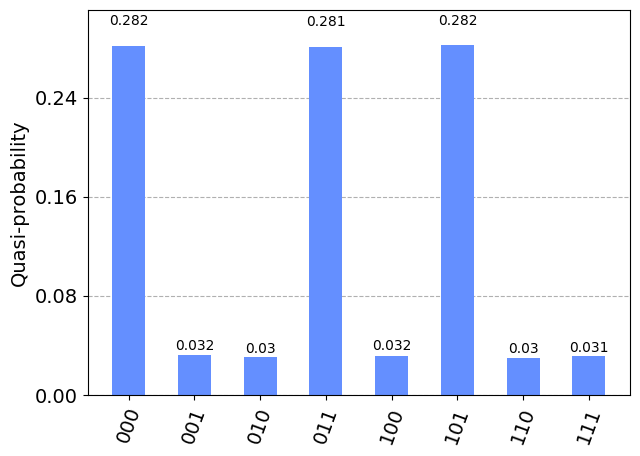

In [26]:
counts = execute_circuit(qc,shots= 100000)
plot_distribution(counts)

# Resolução por matrix

In [16]:
def solucao(expression,param,n_qubits,n_formulas):
    lines = expression.split("\n")
    n_qubits = int(lines[1].split(" ")[2])
    n_formulas = int(lines[1].split(" ")[3])
    #Oracle
    for i in range(n_formulas):
        #Oracle
        valores = []
        line = lines[i+2].split(" ")[:-1]
        resul = 0 

        for j in range(n_qubits):
            if line[j][0] == '-':
                if param[j] == '0':
                    resul = 1
            else:
                if param[j] != '0':
                    resul = 1
        if resul == 0 :
            return False
    return True

In [17]:
def sat_solutions(expression,n_qubits):
    matrix = []
    for i in range(2**n_qubits):
        if solucao(expression,get_bin(i,n_qubits)):
            matrix.append(get_bin(i,n_qubits))
    return matrix

In [19]:
def solucao(expression,param,n_qubits,n_formulas):
    lines = expression.split("\n")
    n_qubits = int(lines[1].split(" ")[2])
    n_formulas = int(lines[1].split(" ")[3])
    #Oracle
    for i in range(n_formulas):
        #Oracle
        valores = []
        line = lines[i+2].split(" ")[:-1]
        resul = 0 

        for j in range(n_qubits):
            if line[j][0] == '-':
                if param[j] == '0':
                    resul = 1
            else:
                if param[j] != '0':
                    resul = 1
        if resul == 0 :
            return False
    return True

n_qubits =3 
get_bin = lambda x, n: format(x, 'b').zfill(n)
qc= QuantumCircuit(3)
matrix = []
for i in range(2**n_qubits):
    add = [0] * (2** n_qubits)
    add[i] = solucao(expression,get_bin(i,n_qubits))
    matrix.append(add)
#qc.unitary(matrix,[0,1,2])


TypeError: solucao() missing 2 required positional arguments: 'n_qubits' and 'n_formulas'

In [20]:

get_bin = lambda x, n: format(x, 'b').zfill(n)

def func1 (expression):
    lines = expression.split("\n")
    n_qubits = int(lines[1].split(" ")[2])
    n_formulas = int(lines[1].split(" ")[3])

    qr = QuantumRegister(n_qubits, name = "psi")
    ancilla = QuantumRegister(1,name = "ancilla")
    cr = ClassicalRegister(n_qubits)

    qc = QuantumCircuit(qr,ancilla ,cr)

    #uniform superposition qr

    qc.h(qr)
    matrix = []
    for i in range(2**n_qubits):
        add = [0] * (2** n_qubits)
        print(get_bin(i,n_qubits))
        add[i] = solucao(expression,get_bin(i,n_qubits))
        matrix.append(add)


    elements = 2**n_qubits

    iterations= int(np.floor(np.pi/4 * np.sqrt(elements)))

    for j in range(iterations):

        qc.barrier()
        qc.unitary(matrix,[0,1,2,3])
        qc.barrier()
        
        #diffusion operator


        qc.h(qr)
        qc.x(qr)
        c3z= MCMT('cz',n_qubits-1,1)
        qc.compose(c3z,qubits=range(n_qubits),inplace=True)
        qc.x(qr)
        qc.h(qr)
        
        qc.barrier()
    
    #for i in range(2,len(lines)):
    return qc,qr,cr



In [ ]:
qc,qr,cr = func1(expression)
qc.measure(qr,cr)
#qc.measure_all()
counts = execute_circuit(qc,shots= 100000)
plot_histogram(counts)
qc.draw(output="mpl")